In [2]:
"""Key Components

1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary."""

'Key Components\n\n1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.\n2. **PlannerState**: A custom type representing the state of our planning process.\n3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).\n4. **LLM Integration**: Utilizing a language model to generate the final itinerary.'

In [3]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.5 MB 1.4 MB/s eta 0:00:02
   ---------------- ----------------------- 1.0/2.5 MB 1.3 MB/s eta 0:00:02
   -------------------- ------------------- 1.3/2.5 MB 1.4 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.5 MB 1.4 MB/s eta 0:00:01
   --------------------------------- ------ 2.1/2.5 MB 1.6 MB/s eta 0:00:01
   ------------------------------------- -- 2.4/2.5 MB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 1.5 MB/s  0:00:01
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ------------------------------ --------- 0.8/1.0 MB 1.9 M

In [1]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [2]:
### Define Agent
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "",
    model_name = "llama-3.3-70b-versatile"
)

#example
result = llm.invoke("What is Multi Ai Agent")
result.content

'A Multi-Agent System (MAS) is a system composed of multiple intelligent agents that interact with each other and their environment to achieve a common goal or set of goals. In the context of Artificial Intelligence (AI), a Multi-AI Agent refers to a system that consists of multiple AI agents that work together to solve complex problems or perform tasks that require coordination and cooperation.\n\nCharacteristics of Multi-AI Agents:\n\n1. **Autonomy**: Each AI agent has its own autonomy to make decisions and take actions.\n2. **Interoperability**: AI agents can communicate and interact with each other to achieve a common goal.\n3. **Distributed problem-solving**: AI agents can work together to solve complex problems that are difficult or impossible for a single agent to solve.\n4. **Flexibility**: Multi-AI Agent systems can adapt to changing environments and requirements.\n\nTypes of Multi-AI Agents:\n\n1. **Homogeneous agents**: All agents have the same capabilities and goals.\n2. **

In [4]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

In [5]:
### Define agent function
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your Input: ")
  return {
      **state,
      "city": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
  user_message = input("Your Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }
def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
  response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary" : response.content,
  }

In [6]:
### Create and compile the graph
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

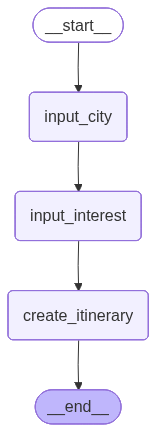

In [7]:
### Display the image graph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [8]:
### Define the function that runs the Graph
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [10]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 


Your Input:  kasaragod


Please enter your interest for the trip to : kasaragod (comma-separted): 


Your Input:  


Creating an itinerary for kasaragod based on interests : 

Final Itinerary: 
For a day trip to Kasaragod, here's a brief, bulleted itinerary based on popular interests:

* 8:00 AM - 9:00 AM: Start the day with a visit to the **Bekal Fort**, a historic fort that offers stunning views of the Arabian Sea.
* 9:30 AM - 11:00 AM: Explore the **Bekal Beach**, known for its pristine shores and picturesque surroundings.
* 11:30 AM - 1:00 PM: Visit the **Valiyaparamba Backwaters**, a scenic spot for boating and relaxation.
* 1:00 PM - 2:30 PM: Take a break for lunch at a local restaurant, trying some of the region's famous cuisine.
* 3:00 PM - 4:30 PM: Stop by the **Chandragiri Fort**, another historic site with breathtaking views of the surrounding landscape.
* 5:00 PM - 6:00 PM: End the day with a visit to the **Kanwatheertha Beach**, a tranquil spot to watch the sunset.

This itinerary provides a mix of history, nature, and relaxation, and can be adjusted based on your specific interests and 

In [11]:
!pip install gradio

In [ ]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="",
    model_name="llama-3.3-70b-versatile"
)

# Define the itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }

def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Define the Gradio application
def travel_planner(city: str, interests: str):
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the city and interests inputs
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme='monochrome',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary",lines=10),
    title="Trip Craft",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

# Launch the Gradio application
interface.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
